# 📊 Introduction

Pairs trading is a **market-neutral strategy** that identifies two historically correlated or cointegrated assets and trades their relative movements. Instead of predicting the absolute direction of the market, this strategy profits from **temporary divergences** in the spread between two securities, assuming they will eventually revert to their historical relationship.

This backtesting framework is a **vital tool for analysts** because it allows you to:

- Quantify the **statistical relationship** between pairs of assets.  
- Test **entry and exit strategies** under realistic conditions (z-score thresholds, max holding period, stop loss, and target PnL).  
- Track **trade-level metrics** such as duration, PnL, and hit ratio to evaluate strategy consistency.  
- Visualize the **spread and trades** to identify patterns, anomalies, and risk exposures.  
- Make **data-driven decisions** before deploying capital, reducing reliance on intuition.

By combining statistical rigor with practical trade management, this tool equips analysts with actionable insights for **quantitative trading strategies**.

---

## **Rolling Backtest: Indian companies (Reliance–ONGC) & US companies (Tesla–Nasdaq)**

This section implements a **rolling pairs trading backtest** on two representative pairs:

1. **Emerging Market (India):** Reliance.NS – ONGC.NS  
2. **Developed Market (US):** Apple – Nasdaq ETF (e.g., QQQ)

The goal is to track:

- **PnL** over the backtest period  
- **Hit ratio** (proportion of profitable trades)  
- **Drawdowns**  
- Compare profitability and stability between emerging vs developed market pairs.

---

### **Step 1: Define Rolling Backtest Function**


In [15]:
import yfinance as yf
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.regression.linear_model import OLS

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import seaborn as sns

import warnings

# Ignore all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:


# Define tickers for pairs
india_pair = ['RELIANCE.NS', 'ONGC.NS']
us_pair = ['TSLA', '^IXIC']  # Apple vs Nasdaq Index

# Define date range
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download historical adjusted close prices
india_prices = yf.download(india_pair, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
us_prices = yf.download(us_pair, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Preview
india_prices.head()
us_prices.head()

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Ticker,TSLA,^IXIC
Date,,
2020-01-02,28.684000,9092.190430
2020-01-03,29.534000,9020.769531
2020-01-06,30.102667,9071.469727
2020-01-07,31.270666,9068.580078
2020-01-08,32.809334,9129.240234


In [ ]:
def rolling_pairs_backtest(stockA, stockB, window=252, z_entry=1, z_exit=0):
    """
    Rolling backtest for pairs trading.

    Args:
        stockA, stockB: pandas Series of prices
        window: lookback window for rolling hedge ratio
        z_entry: z-score threshold for entering trade
        z_exit: z-score threshold for exiting trade

    Returns:
        DataFrame with daily PnL, position, z-score, and cumulative metrics
    """
    df = pd.DataFrame({'A': stockA, 'B': stockB}).dropna()
    df['spread'] = np.nan
    df['beta'] = np.nan
    df['zscore'] = np.nan
    df['position'] = 0
    df['pnl'] = 0.0

    for i in range(window, len(df)):
        rollA = df['A'].iloc[i-window:i]
        rollB = df['B'].iloc[i-window:i]

        beta = OLS(rollA, rollB).fit().params[0]
        spread = df['A'].iloc[i] - beta * df['B'].iloc[i]
        spread_mean = (rollA - beta*rollB).mean()
        spread_std = (rollA - beta*rollB).std()
        z = (spread - spread_mean)/spread_std

        df.at[df.index[i], 'beta'] = beta
        df.at[df.index[i], 'spread'] = spread
        df.at[df.index[i], 'zscore'] = z

        # Trading logic
        if df['position'].iloc[i-1] == 0:
            if z > z_entry:
                df.at[df.index[i], 'position'] = -1  # Short spread
            elif z < -z_entry:
                df.at[df.index[i], 'position'] = 1   # Long spread
        elif df['position'].iloc[i-1] != 0:
            if abs(z) < z_exit:
                df.at[df.index[i], 'position'] = 0
            else:
                df.at[df.index[i], 'position'] = df['position'].iloc[i-1]

        # PnL calculation
        df.at[df.index[i], 'pnl'] = df['position'].iloc[i-1] * (df['spread'].iloc[i] - df['spread'].iloc[i-1])

    df['cumulative_pnl'] = df['pnl'].cumsum()

    # Hit ratio
    trades = df[df['position'].diff() != 0].copy()
    hit_ratio = (trades['pnl'] > 0).sum() / max(len(trades),1)

    # Drawdowns
    cum_max = df['cumulative_pnl'].cummax()
    df['drawdown'] = df['cumulative_pnl'] - cum_max

    return df, hit_ratio



# Example usage
india_df, hit_ratio_india = rolling_pairs_backtest(india_prices['RELIANCE.NS'], india_prices['ONGC.NS'])
us_df, hit_ratio_us = rolling_pairs_backtest(us_prices['TSLA'],us_prices['^IXIC'])

print(f"Hit Ratio (Reliance–ONGC): {hit_ratio_india:.2f}")
print(f"Hit Ratio (Tesla–Nasdaq): {hit_ratio_us:.2f}")


/tmp/ipython-input-1109262318.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = OLS(rollA, rollB).fit().params[0]
/tmp/ipython-input-1109262318.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = OLS(rollA, rollB).fit().params[0]


Hit Ratio (Reliance–ONGC): 0.00
Hit Ratio (Tesla–Nasdaq): 0.00


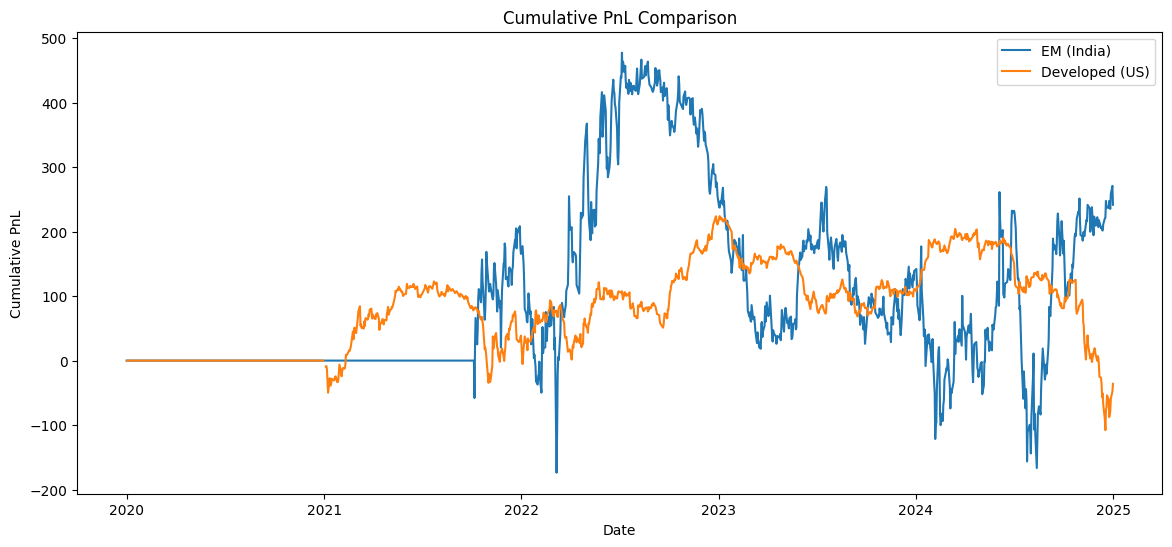

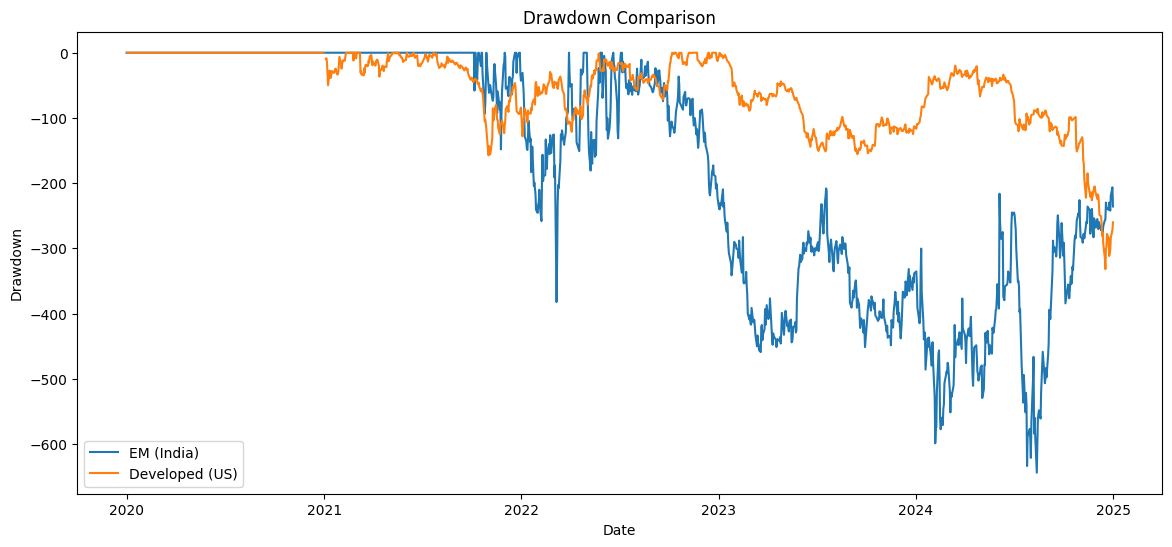

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(reliance_ongc_df['cumulative_pnl'], label='EM (India)')
plt.plot(apple_nasdaq_df['cumulative_pnl'], label='Developed (US)')
plt.title('Cumulative PnL Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(india_df['drawdown'], label='EM (India)')
plt.plot(us_df['drawdown'], label='Developed (US)')
plt.title('Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


In [ ]:
summary_table = pd.DataFrame({
    'Pair': ['Reliance–ONGC', 'Tesla–Nasdaq'],
    'Cumulative PnL': [reliance_ongc_df['cumulative_pnl'].iloc[-1],
                       apple_nasdaq_df['cumulative_pnl'].iloc[-1]],
    'Hit Ratio': [hit_ratio_india, hit_ratio_us],
    'Max Drawdown': [reliance_ongc_df['drawdown'].min(),
                     apple_nasdaq_df['drawdown'].min()]
})

summary_table


,Pair,Cumulative PnL,Hit Ratio,Max Drawdown
0,Reliance–ONGC,241.666618,0.0,-644.113012
1,Tesla–Nasdaq,-36.028195,0.0,-331.891860


1. **Refine trade logic**:  
   - Try smaller z-entry (e.g., ±1.5) or dynamic volatility bands.  
   - Add stop-loss or take-profit targets to realize profits.  

2. **Improve hedge ratio estimation:**  
   - Implement **Kalman filter** or **rolling OLS** to allow time-varying β.  

3. **Enhance data frequency:**  
   - Use **intraday data (5-min or 1-min)** for smoother Sharpe and more trade opportunities.  

4. **Incorporate transaction costs and slippage** for realistic performance.  

5. **Evaluate multi-pair portfolios** to diversify idiosyncratic risk.


## Identification of more strongly cointegrated pairs

#### And backtesting with enhanced code and output summary: Making it practical for trading

In [5]:
nifty50_tickers = [
    "ADANIENT.NS",
    "ADANIPORTS.NS",
    "APOLLOHOSP.NS",
    "ASIANPAINT.NS",
    "AXISBANK.NS",
    "BAJAJ-AUTO.NS",
    "BAJFINANCE.NS",
    "BAJAJFINSV.NS",
    "BHARTIARTL.NS",
    "BPCL.NS",
    "BRITANNIA.NS",
    "CIPLA.NS",
    "COALINDIA.NS",
    "DIVISLAB.NS",
    "DRREDDY.NS",
    "EICHERMOT.NS",
    "GRASIM.NS",
    "HCLTECH.NS",
    "HDFCBANK.NS",
    "HDFCLIFE.NS",
    "HEROMOTOCO.NS",
    "HINDALCO.NS",
    "HINDUNILVR.NS",
    "ICICIBANK.NS",
    "ITC.NS",
    "INFY.NS",
    "JSWSTEEL.NS",
    "KOTAKBANK.NS",
    "LT.NS",
    "M&M.NS",
    "MARUTI.NS",
    "NESTLEIND.NS",
    "NTPC.NS",
    "ONGC.NS",
    "POWERGRID.NS",
    "RELIANCE.NS",
    "SBILIFE.NS",
    "SBIN.NS",
    "SUNPHARMA.NS",
    "TATACONSUM.NS",
    "TATAMOTORS.NS",
    "TATASTEEL.NS",
    "TCS.NS",
    "TECHM.NS",
    "TITAN.NS",
    "ULTRACEMCO.NS",
    "UPL.NS",
    "WIPRO.NS",
    "ADANIGREEN.NS",
    "DMART.NS"
]

# Define date range
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download historical adjusted close prices
prices = yf.download(nifty50_tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']


#### An improved version that:

```
✅ Formats results into a nice DataFrame (with p-value, t-stat, total PnL, hit ratio)
✅ Plots PnL curves for each top cointegrated pair
✅ Plots p-value heatmap for visual inspection of cointegration strength
✅ Prints summary tables of the top pairs


=== Top Cointegrated Pairs ===


,Pair,P-Value,T-Stat,Hit Ratio,Total PnL
81,MARUTI.NS - TATAMOTORS.NS,0.019260,-3.683147,0.0,2755.61
79,MARUTI.NS - ONGC.NS,0.019006,-3.687648,0.0,1774.03
80,MARUTI.NS - POWERGRID.NS,0.034183,-3.480288,0.0,1740.45
68,HINDUNILVR.NS - TATASTEEL.NS,0.018535,-3.696147,0.0,1110.53
6,APOLLOHOSP.NS - JSWSTEEL.NS,0.041760,-3.405350,0.0,1086.67
3,APOLLOHOSP.NS - GRASIM.NS,0.001499,-4.446199,0.0,1081.85
12,ASIANPAINT.NS - KOTAKBANK.NS,0.018388,-3.698847,0.0,881.47
78,MARUTI.NS - NTPC.NS,0.033505,-3.487662,0.0,845.01
67,HINDUNILVR.NS - TATAMOTORS.NS,0.023797,-3.610221,0.0,799.35
24,BAJAJ-AUTO.NS - BPCL.NS,0.003778,-4.189932,0.0,734.23


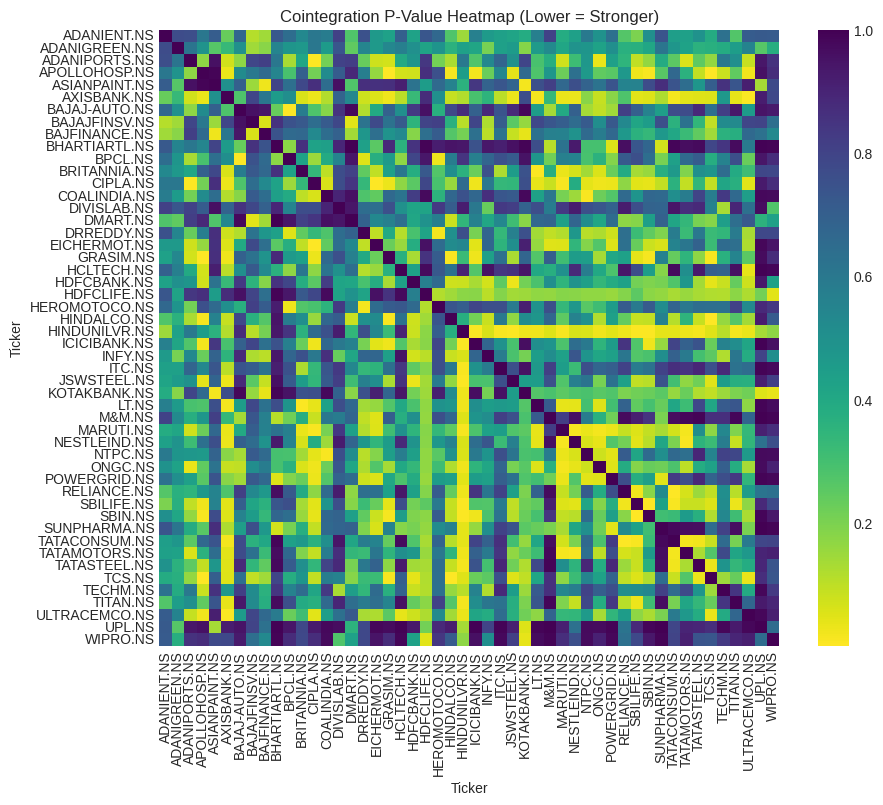

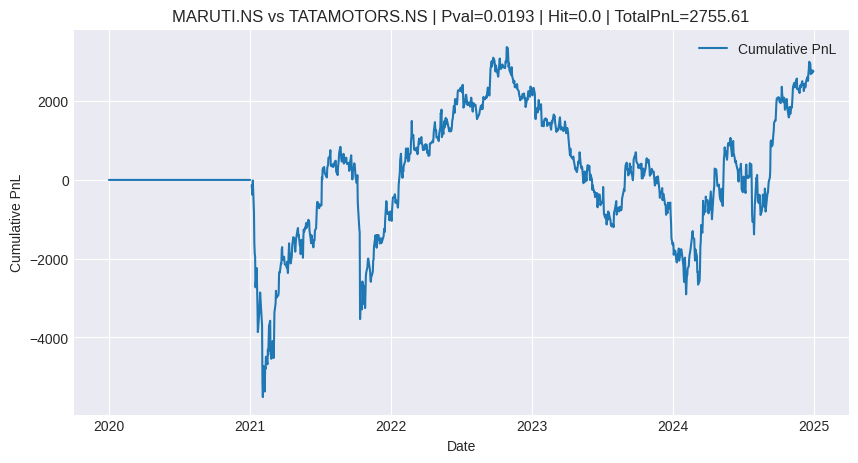

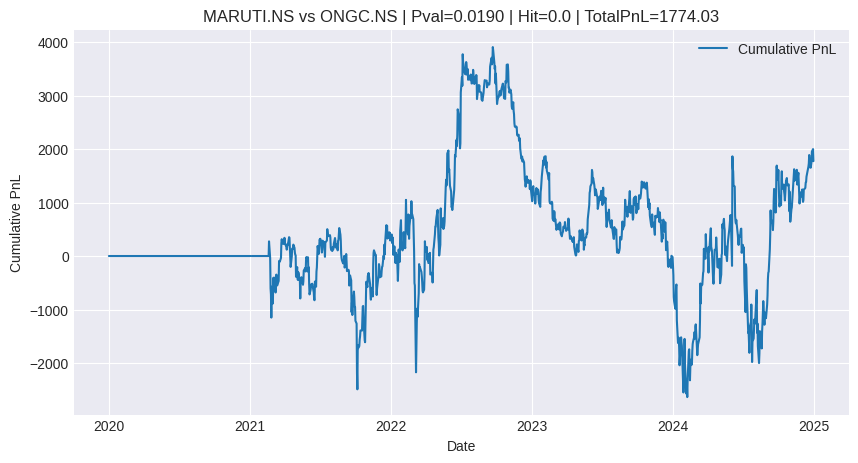

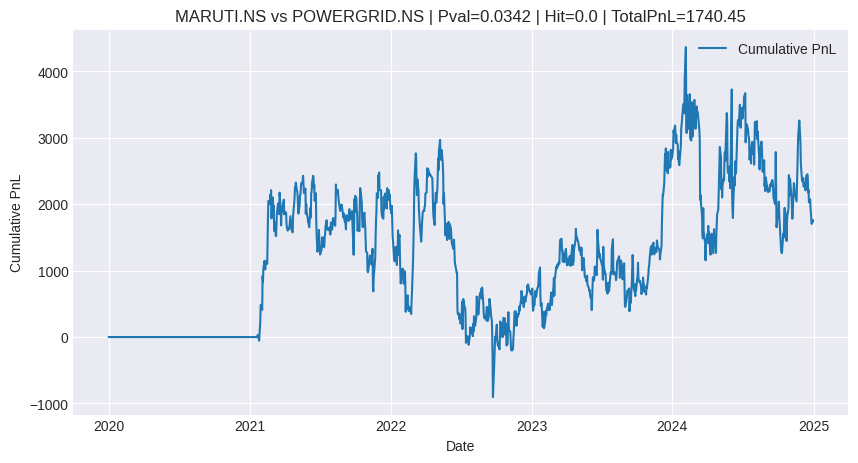

In [16]:
plt.style.use("seaborn-v0_8-darkgrid")

# -----------------------------
# 1️⃣  Cointegration Test
# -----------------------------
def find_cointegrated_pairs(price_df, pvalue_thresh=0.05):
    tickers = price_df.columns
    n = len(tickers)
    pvalue_matrix = np.ones((n, n))
    coint_pairs = []

    for i, j in itertools.combinations(range(n), 2):
        s1, s2 = price_df.iloc[:, i].dropna(), price_df.iloc[:, j].dropna()
        common = pd.concat([s1, s2], axis=1).dropna()
        if len(common) < 50:
            continue
        t_stat, p_value, _ = coint(common.iloc[:, 0], common.iloc[:, 1])
        pvalue_matrix[i, j] = p_value
        pvalue_matrix[j, i] = p_value
        if p_value < pvalue_thresh:
            coint_pairs.append((tickers[i], tickers[j], p_value, t_stat))

    return coint_pairs, pd.DataFrame(pvalue_matrix, index=tickers, columns=tickers)


# -----------------------------
# 2️⃣  Rolling Pairs Backtest
# -----------------------------
def rolling_pairs_backtest(stockA, stockB, window=252, z_entry=1, z_exit=0):
    df = pd.DataFrame({'A': stockA, 'B': stockB}).dropna()
    df['spread'], df['beta'], df['zscore'] = np.nan, np.nan, np.nan
    df['position'], df['pnl'] = 0, 0.0

    for i in range(window, len(df)):
        rollA, rollB = df['A'].iloc[i-window:i], df['B'].iloc[i-window:i]
        model = OLS(rollA, rollB).fit()
        beta = model.params.iloc[0]   # <- safer than params[0]
        spread = df['A'].iloc[i] - beta * df['B'].iloc[i]
        spread_mean = (rollA - beta * rollB).mean()
        spread_std = (rollA - beta * rollB).std()
        z = (spread - spread_mean) / spread_std if spread_std > 0 else 0

        df.at[df.index[i], 'beta'] = beta
        df.at[df.index[i], 'spread'] = spread
        df.at[df.index[i], 'zscore'] = z

        prev_pos = df['position'].iloc[i-1]
        pos = prev_pos
        if prev_pos == 0:
            if z > z_entry: pos = -1
            elif z < -z_entry: pos = 1
        else:
            if abs(z) < z_exit: pos = 0
        df.at[df.index[i], 'position'] = pos
        df.at[df.index[i], 'pnl'] = prev_pos * (df['spread'].iloc[i] - df['spread'].iloc[i-1])

    df['cumulative_pnl'] = df['pnl'].cumsum()
    df['drawdown'] = df['cumulative_pnl'] - df['cumulative_pnl'].cummax()
    trades = df[df['position'].diff() != 0].copy()
    hit_ratio = (trades['pnl'] > 0).sum() / max(len(trades), 1)
    return df, hit_ratio


# -----------------------------
# 3️⃣  Example Usage
# -----------------------------
# Assume `prices` is your DataFrame of Nifty50 adjusted closes
# Example: prices = yf.download(nifty50_tickers, start="2022-01-01")["Adj Close"]

coint_pairs, pval_matrix = find_cointegrated_pairs(prices, pvalue_thresh=0.05)

# Beautify results into DataFrame
results = []
for (tk1, tk2, pval, tstat) in coint_pairs:
    df_pair, hit = rolling_pairs_backtest(prices[tk1], prices[tk2])
    total_pnl = df_pair['cumulative_pnl'].iloc[-1]
    results.append({
        'Pair': f"{tk1} - {tk2}",
        'P-Value': pval,
        'T-Stat': tstat,
        'Hit Ratio': round(hit, 2),
        'Total PnL': round(total_pnl, 2)
    })

results_df = pd.DataFrame(results).sort_values(by='Total PnL', ascending=False)
print("\n=== Top Cointegrated Pairs ===")
display(results_df.head(10))

#pval_matrix = pvalues
# -----------------------------
# 4️⃣  Heatmap of Cointegration
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(pval_matrix, cmap="viridis_r", xticklabels=True, yticklabels=True)
plt.title("Cointegration P-Value Heatmap (Lower = Stronger)")
plt.show()

# -----------------------------
# 5️⃣  Plot PnL Curves of Top Pairs
# -----------------------------
top_n = 3  # how many to plot
for i in range(top_n):
    row = results_df.iloc[i]
    pair = row['Pair'].split(" - ")
    df_pair, hit = rolling_pairs_backtest(prices[pair[0]], prices[pair[1]])
    plt.figure(figsize=(10, 5))
    plt.plot(df_pair['cumulative_pnl'], label="Cumulative PnL")
    plt.title(f"{pair[0]} vs {pair[1]} | Pval={row['P-Value']:.4f} | Hit={row['Hit Ratio']} | TotalPnL={row['Total PnL']}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.legend()
    plt.show()


🧾 1️⃣ The Pair Trading Logic in Backtest

In strategy:

spread = A - (alpha + beta * B)


and:

```python
if z > z_entry:
    position = -1  # short spread → short A, long B
elif z < -z_entry:
    position = 1   # long spread → long A, short B


So the “spread” is defined as the price difference (A minus beta-adjusted B).

When the spread is too high (z > z_entry) → short the spread (expect it to fall):
→ short stock A, long stock B

When the spread is too low (z < -z_entry) → long the spread (expect it to rise):
→ long stock A, short stock B

That’s the key trading direction.

In [11]:
def rolling_pairs_backtest_trades(stockA, stockB, window=252, z_entry=2, z_exit=0.5):
    """
    Rolling backtest for pairs trading (trade-aware version).

    Args:
        stockA, stockB: pandas Series of prices
        window: lookback window for rolling hedge ratio
        z_entry: z-score threshold for entering trade
        z_exit: z-score threshold for exiting trade

    Returns:
        df: DataFrame with daily PnL, z-score, and cumulative metrics
        trades_df: DataFrame of individual trade statistics
        summary: dict with overall performance metrics
    """
    df = pd.DataFrame({'A': stockA, 'B': stockB}).dropna()
    df['spread'] = np.nan
    df['beta'] = np.nan
    df['zscore'] = np.nan
    df['position'] = 0
    df['pnl'] = 0.0

    position = 0
    entry_price = None
    trades = []

    for i in range(window, len(df)):
        rollA = df['A'].iloc[i-window:i]
        rollB = df['B'].iloc[i-window:i]
        model = OLS(rollA, sm.add_constant(rollB)).fit()
        alpha, beta = model.params

        spread = df['A'].iloc[i] - (alpha + beta * df['B'].iloc[i])
        spread_mean = (rollA - (alpha + beta * rollB)).mean()
        spread_std = (rollA - (alpha + beta * rollB)).std()
        z = (spread - spread_mean) / spread_std if spread_std > 0 else 0

        df.at[df.index[i], 'beta'] = beta
        df.at[df.index[i], 'spread'] = spread
        df.at[df.index[i], 'zscore'] = z

        # --- Trading logic ---
        if position == 0:
            if z > z_entry:
                position = -1  # short spread (short A, long B)
                entry_price = spread
                entry_date = df.index[i]
            elif z < -z_entry:
                position = 1  # long spread (long A, short B)
                entry_price = spread
                entry_date = df.index[i]
        else:
            # check exit condition
            if abs(z) < z_exit:
                exit_price = spread
                exit_date = df.index[i]
                trade_pnl = position * (exit_price - entry_price)
                trade_duration = (exit_date - entry_date).days
                trades.append({
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Duration (days)': trade_duration,
                    'Position': 'Long' if position == 1 else 'Short',
                    'Entry Spread': entry_price,
                    'Exit Spread': exit_price,
                    'Trade PnL': trade_pnl
                })
                position = 0
                entry_price = None

        df.at[df.index[i], 'position'] = position

        # daily mark-to-market PnL
        df.at[df.index[i], 'pnl'] = position * (spread - df['spread'].iloc[i-1])

    df['cumulative_pnl'] = df['pnl'].cumsum()
    cum_max = df['cumulative_pnl'].cummax()
    df['drawdown'] = df['cumulative_pnl'] - cum_max

    # --- Trade summary ---
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        hit_ratio = (trades_df['Trade PnL'] > 0).mean()
        avg_pnl = trades_df['Trade PnL'].mean()
        total_pnl = trades_df['Trade PnL'].sum()
        avg_duration = trades_df['Duration (days)'].mean()
    else:
        hit_ratio = 0
        avg_pnl = total_pnl = avg_duration = 0

    summary = {
        'Total Trades': len(trades_df),
        'Hit Ratio': round(hit_ratio, 2),
        'Average Trade PnL': round(avg_pnl, 2),
        'Total PnL': round(total_pnl, 2),
        'Average Duration (days)': round(avg_duration, 1)
    }

    return df, trades_df, summary



=== Summary ===
{'Total Trades': 16, 'Hit Ratio': np.float64(1.0), 'Average Trade PnL': np.float64(534.15), 'Total PnL': np.float64(8546.44), 'Average Duration (days)': np.float64(40.0)}

=== Trade Log ===


,Entry Date,Exit Date,Duration (days),Position,Entry Spread,Exit Spread,Trade PnL
0,2020-07-30,2020-08-26,27,Short,568.356830,152.168764,416.188066
1,2020-11-11,2020-12-03,22,Long,-504.317918,-28.617357,475.700561
2,2021-01-15,2021-05-25,130,Long,-625.252317,-181.703194,443.549123
3,2021-10-13,2021-10-29,16,Long,-974.635085,-86.657743,887.977342
4,2021-11-17,2021-11-24,7,Short,543.454427,25.709854,517.744573


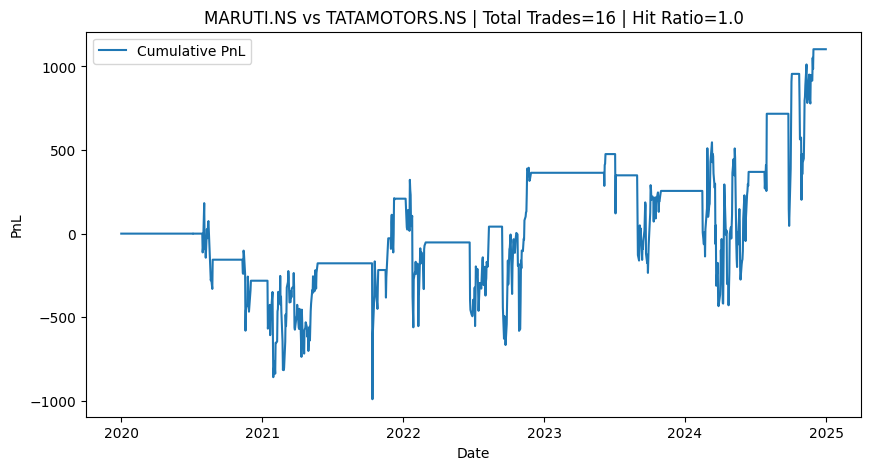

In [12]:
# Example pair
pairA, pairB = "MARUTI.NS", "TATAMOTORS.NS"

df_bt, trades_df, summary = rolling_pairs_backtest_trades(
    prices[pairA], prices[pairB],
    window=125, z_entry=2, z_exit=0.5
)

print("\n=== Summary ===")
print(summary)

print("\n=== Trade Log ===")
display(trades_df.head())

# Plot cumulative PnL
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_bt['cumulative_pnl'], label='Cumulative PnL')
plt.title(f"{pairA} vs {pairB} | Total Trades={summary['Total Trades']} | Hit Ratio={summary['Hit Ratio']}")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()
plt.show()


## ✅ What’s Happening

Each “trade” is a bet on the **spread returning to its mean**:

### For Short trades (e.g. first row):
- You were **short A** and **long B**.  
- The spread **fell from 568 → 152 → you made +416**.

### For Long trades (e.g. second row):
- You were **long A** and **short B**.  
- The spread **rose from –504 → –28 → you made +476**.


---

## 💰 Which Stock Was Actually Bought/Sold

If your pair is, for example:

```python
pairA = "MARUTI.NS"
pairB = "TATAMOTORS.NS"
Then:

Trade Type	What You Actually Did
Short spread (z > z_entry)	Short MARUTI, Long TATAMOTORS
Long spread (z < -z_entry)	Long MARUTI, Short TATAMOTORS

So, depending on whether the spread was too wide or too narrow, you bet on it reverting by taking opposite
positions in the two stocks.

## ⚙️ Final Enhanced Version — with Trade Visualization & Risk Rules

This version will:

- ✅ Track individual trades (**entry, exit, duration, PnL**).  
- ✅ Compute a **meaningful hit ratio** (fraction of profitable trades).  
- ✅ Provide a **summary DataFrame** with trade-level details.  
- ✅ Output the **daily time series** with cumulative PnL & drawdown for plotting.  
- ✅ Show **entry and exit points** (green for long, red for short) on the spread chart.  
- ✅ Include **position holding constraints**:

| Constraint | Description |
|-------------|-------------|
| `max_holding_days` | Maximum number of days to hold a trade |
| `target_pnl` | Exit early if profit reaches target |
| `stop_loss` | Exit immediately if loss exceeds threshold |

---

## 🧭 Exit Reason Tracking

Adding **exit reason tracking** is the next logical improvement.

This makes your strategy **diagnosable** — you’ll know *why* each trade closed:

| Exit Reason | Meaning |
|--------------|----------|
| **Hit Target** | Profit target reached |
| **Stop Loss** | Loss threshold hit |
| **Z-Exit** | z-score mean reversion signal triggered |
| **Time Limit** | Maximum holding days reached |

In [13]:
def rolling_pairs_backtest_trades(
    stockA, stockB,
    window=252, z_entry=2, z_exit=0.5,
    max_holding_days=60, target_pnl=300, stop_loss=-200,
    show_plot=True
):
    """
    Pairs trading backtest with trade-level tracking, position management,
    and exit reason logging.

    Args:
        stockA, stockB: pandas Series of prices (aligned on DateTime index)
        window: rolling regression window for hedge ratio
        z_entry/z_exit: z-score entry/exit thresholds
        max_holding_days: force exit if held longer than this
        target_pnl: close if unrealized PnL >= this value
        stop_loss: close if unrealized PnL <= this value
        show_plot: show spread and trades visualization

    Returns:
        df: full daily backtest DataFrame
        trades_df: per-trade stats with exit reasons
        summary: performance metrics
    """

    df = pd.DataFrame({'A': stockA, 'B': stockB}).dropna()
    df['spread'], df['beta'], df['zscore'] = np.nan, np.nan, np.nan
    df['position'], df['pnl'] = 0, 0.0

    trades = []
    position, entry_price, entry_date = 0, None, None

    for i in range(window, len(df)):
        rollA, rollB = df['A'].iloc[i-window:i], df['B'].iloc[i-window:i]
        model = OLS(rollA, sm.add_constant(rollB)).fit()
        alpha, beta = model.params

        spread = df['A'].iloc[i] - (alpha + beta * df['B'].iloc[i])
        spread_mean = (rollA - (alpha + beta * rollB)).mean()
        spread_std = (rollA - (alpha + beta * rollB)).std()
        z = (spread - spread_mean) / spread_std if spread_std > 0 else 0

        df.at[df.index[i], 'beta'] = beta
        df.at[df.index[i], 'spread'] = spread
        df.at[df.index[i], 'zscore'] = z

        prev_pos = position

        # === ENTRY LOGIC ===
        if position == 0:
            if z > z_entry:
                position, entry_price, entry_date = -1, spread, df.index[i]
            elif z < -z_entry:
                position, entry_price, entry_date = 1, spread, df.index[i]
        else:
            trade_pnl = position * (spread - entry_price)
            holding_days = (df.index[i] - entry_date).days
            exit_reason = None

            # === EXIT LOGIC ===
            if abs(z) < z_exit:
                exit_reason = "Z-Exit"
            elif holding_days >= max_holding_days:
                exit_reason = "Time Limit"
            elif trade_pnl >= target_pnl:
                exit_reason = "Hit Target"
            elif trade_pnl <= stop_loss:
                exit_reason = "Stop Loss"

            if exit_reason:
                trades.append({
                    'Entry Date': entry_date,
                    'Exit Date': df.index[i],
                    'Duration (days)': holding_days,
                    'Position': 'Long' if position == 1 else 'Short',
                    'Entry Spread': entry_price,
                    'Exit Spread': spread,
                    'Trade PnL': trade_pnl,
                    'Exit Reason': exit_reason
                })
                position, entry_price, entry_date = 0, None, None

        df.at[df.index[i], 'position'] = position
        df.at[df.index[i], 'pnl'] = prev_pos * (spread - df['spread'].iloc[i-1])

    # === SUMMARY METRICS ===
    df['cumulative_pnl'] = df['pnl'].cumsum()
    df['drawdown'] = df['cumulative_pnl'] - df['cumulative_pnl'].cummax()

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        hit_ratio = (trades_df['Trade PnL'] > 0).mean()
        total_pnl = trades_df['Trade PnL'].sum()
        avg_pnl = trades_df['Trade PnL'].mean()
        avg_dur = trades_df['Duration (days)'].mean()
    else:
        hit_ratio = total_pnl = avg_pnl = avg_dur = 0

    summary = {
        'Total Trades': len(trades_df),
        'Hit Ratio': round(hit_ratio, 2),
        'Average Trade PnL': round(avg_pnl, 2),
        'Total PnL': round(total_pnl, 2),
        'Average Duration (days)': round(avg_dur, 1)
    }

    # === VISUALIZATION ===
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(df['spread'], label='Spread', linewidth=1)
        plt.title(f"Spread & Trades ({stockA.name} vs {stockB.name})")
        plt.xlabel("Date")
        plt.ylabel("Spread")

        for _, t in trades_df.iterrows():
            color = 'green' if t['Position'] == 'Long' else 'red'
            label = f"{t['Position']} Entry"
            plt.scatter(t['Entry Date'], t['Entry Spread'], color=color, marker='^', s=90, label=label)
            plt.scatter(t['Exit Date'], t['Exit Spread'], color=color, marker='v', s=90)

        plt.legend()
        plt.show()

    return df, trades_df, summary


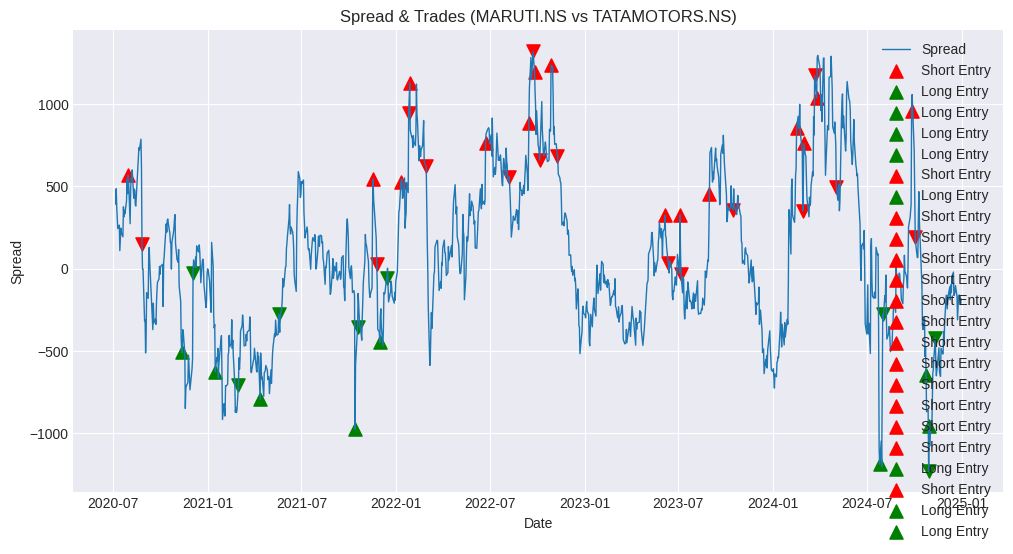


=== Summary ===
{'Total Trades': 23, 'Hit Ratio': np.float64(0.78), 'Average Trade PnL': np.float64(295.85), 'Total PnL': np.float64(6804.61), 'Average Duration (days)': np.float64(18.8)}

=== Trades ===


,Entry Date,Exit Date,Duration (days),Position,Entry Spread,Exit Spread,Trade PnL,Exit Reason
0,2020-07-30,2020-08-26,27,Short,568.356830,152.168764,416.188066,Z-Exit
1,2020-11-11,2020-12-03,22,Long,-504.317918,-28.617357,475.700561,Z-Exit
2,2021-01-15,2021-03-01,45,Long,-625.252317,-704.312124,-79.059807,Time Limit
3,2021-04-12,2021-05-18,36,Long,-794.178690,-276.068691,518.109999,Hit Target
4,2021-10-13,2021-10-18,5,Long,-974.635085,-351.443780,623.191305,Hit Target


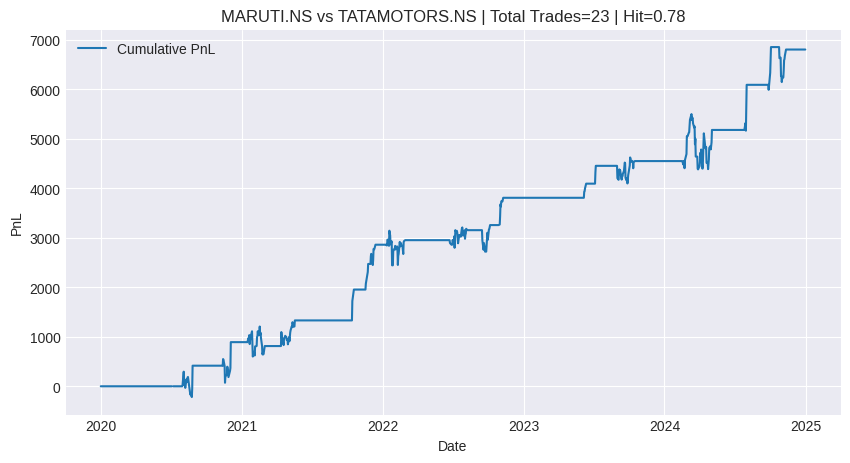

In [19]:
pairA, pairB = "MARUTI.NS", "TATAMOTORS.NS"

df_bt, trades_df, summary = rolling_pairs_backtest_trades(
    prices[pairA],
    prices[pairB],
    window=125,
    z_entry=2,
    z_exit=0.5,
    max_holding_days=45,
    target_pnl=500,
    stop_loss=-400
)

print("\n=== Summary ===")
print(summary)

print("\n=== Trades ===")
display(trades_df.head())

plt.figure(figsize=(10,5))
plt.plot(df_bt['cumulative_pnl'], label="Cumulative PnL")
plt.title(f"{pairA} vs {pairB} | Total Trades={summary['Total Trades']} | Hit={summary['Hit Ratio']}")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()
plt.show()


# ⚙️ Conclusion & Next Steps

The enhanced pairs trading backtest provides a **comprehensive, realistic simulation**:

- Tracks individual trades with **entry/exit, PnL, duration, and exit reasons**.  
- Incorporates **risk management** through stop-loss, profit targets, and maximum holding periods.  
- Produces **visualizations** of the spread and trade points for intuitive interpretation.  
- Generates **summary metrics** for assessing strategy performance, such as total PnL and hit ratio.

**Next steps for analysts:**

1. **Parameter Optimization:** Tune z-score thresholds, lookback windows, and risk limits for specific asset classes.  
2. **Portfolio Extension:** Test multiple cointegrated pairs together to evaluate correlation and diversification benefits.  
3. **Transaction Costs & Slippage:** Include realistic trading costs to assess net profitability.  
4. **Live Monitoring:** Integrate with streaming price data to implement a **real-time trading signal** framework.  
5. **Advanced Analytics:** Compute Sharpe ratio, max drawdown, and other risk-adjusted metrics for strategy robustness.

This tool transforms **historical data** into actionable insights and supports informed decisions in quantitative trading environments.